# **NEURAL NETWORK BINARY CLASSIFICATION**

## 1. Making data

In [1]:
import sklearn 
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
n_samples = 1000
x, y = make_circles(n_samples, noise=0.03, random_state=42)
len(x),len(y)

(1000, 1000)

In [3]:
print(f"First 5 samples of x: \n{x[:5]}")
print(f"First 5 samples of y: \n{y[:5]}")

First 5 samples of x: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: 
[1 1 1 1 0]


In [4]:
circles = pd.DataFrame({
    "x1":x[:,0],
    "x2":x[:,1],
    "label":y
})
circles.head()

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


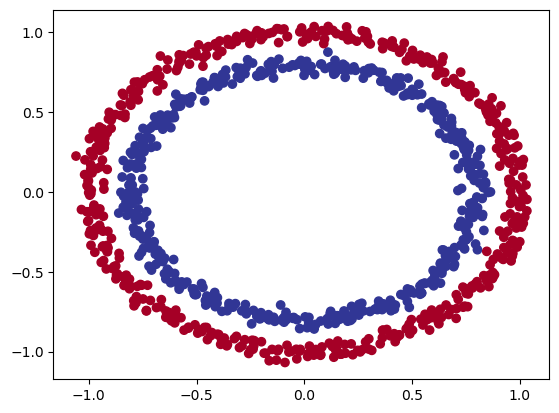

In [5]:
plt.scatter(x=x[:,0],y=x[:,1],c=y,cmap=plt.cm.RdYlBu)

Note: the data we're with is often referred to as toy dataset, a dataset that is small enought to experiment but still sizeable enough to expriment on 

### 1.1 check input and output shapes

In [6]:
x.shape, y.shape

((1000, 2), (1000,))

### 1.2 Turn data into tensors and create train, test split

In [7]:
import torch


In [8]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
type(x), x.dtype

(torch.Tensor, torch.float32)

In [9]:
x[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42)
len(xtrain),len(xtest),len(ytrain),len(ytest)

(800, 200, 800, 200)

## 2. Building a model


to do: 
1. setup a device agonistic code
2. construct model 
3. setup a loss function and optimizer
4. create a training and testing loop

In [11]:
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

now we create a device agnoistit code 
1. subclasses `nn.Module`
2. create a `nn.Linear()`
3. defines a `forward()` method that outlines the forward pass
4. intantiate an instance of model class and sent it to target device

In [12]:
class CircleModelv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=5) # input layer
        self.layer_2 = nn.Linear(in_features=5,out_features=1) # output layer
        
    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.layer_2(self.layer_1(x))                   # x -> layer 1 -> layer 2 -> output
    

model = CircleModelv1().to(device)
model

CircleModelv1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
next(model.parameters()).device

device(type='cuda', index=0)

other way is `nn.sequential`

In [14]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5), nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2705,  0.2415],
                      [ 0.1524,  0.6842],
                      [-0.6600, -0.0250],
                      [-0.4263, -0.0904],
                      [ 0.2933, -0.2647]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6381,  0.1983, -0.1537,  0.3469, -0.3362], device='cuda:0')),
             ('1.weight',
              tensor([[-0.0876, -0.1208,  0.2495, -0.3799,  0.3993]], device='cuda:0')),
             ('1.bias', tensor([-0.1531], device='cuda:0'))])

In [16]:
model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.6629, -0.2433],
                      [ 0.2416,  0.6894],
                      [ 0.4225,  0.5605],
                      [-0.5816,  0.5563],
                      [ 0.1643, -0.2659]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.3745,  0.0392, -0.2600, -0.4192, -0.1947], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.0919, -0.2291, -0.2177, -0.1965, -0.3026]], device='cuda:0')),
             ('layer_2.bias', tensor([0.3602], device='cuda:0'))])

now we setup a loss function and optimizer 


- for classifiction we might need to use binary cross entorpy or categorical cross entropy


In [17]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params= model.parameters(),lr=0.1)

In [18]:
# evaluation metrics 
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    return (correct/len(y_pred))*100

our model ouputs are goint to be raw **logits**

we can conveert these **logits** into prediction probab by passing them to some kind of activation function 

then we can convert our mmodels probabilites to predictionlabels by either rounding them or taking `argmax`

In [19]:
with torch.inference_mode():
    y_logits = model(xtest.to(device))[:5]
ypredprobs = torch.sigmoid(y_logits)
torch.round(ypredprobs)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')

In [20]:
#building training and testing loops
epochs = 100

xtrain,ytrain = xtrain.to(device), ytrain.to(device)
xtest,ytest = xtest.to(device), ytest.to(device)


for epoch in range(epochs):
    model.train()
    
    ylogits = model(xtrain).squeeze()
    ypred = torch.round(torch.sigmoid(ylogits))
    
    train_loss = loss_fn(ylogits,ytrain)
    acc = accuracy_fn(y_true=ytrain, y_pred=ypred)
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()
    
    
    
    model.eval()
    with torch.inference_mode():
        test_logits = model(xtest).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_pred,ytest)
        test_acc = accuracy_fn(y_true=ytest,y_pred=test_pred)
        
        
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | loss: {train_loss } | acc: {acc} | test loss {test_loss} | test acc: {test_acc}')
    

Epoch: 0 | loss: 0.7332445979118347 | acc: 50.0 | test loss 0.8132616877555847 | test acc: 50.0
Epoch: 10 | loss: 0.7125057578086853 | acc: 50.0 | test loss 0.8132616877555847 | test acc: 50.0
Epoch: 20 | loss: 0.7034092545509338 | acc: 51.37500000000001 | test loss 0.7729542851448059 | test acc: 56.49999999999999
Epoch: 30 | loss: 0.6991740465164185 | acc: 55.875 | test loss 0.7511382699012756 | test acc: 57.49999999999999
Epoch: 40 | loss: 0.6970498561859131 | acc: 53.37499999999999 | test loss 0.7667245268821716 | test acc: 51.5
Epoch: 50 | loss: 0.6958810091018677 | acc: 52.75 | test loss 0.7669199109077454 | test acc: 50.5
Epoch: 60 | loss: 0.6951690316200256 | acc: 51.87500000000001 | test loss 0.7676182389259338 | test acc: 50.0
Epoch: 70 | loss: 0.6946921944618225 | acc: 51.24999999999999 | test loss 0.764014720916748 | test acc: 50.0
Epoch: 80 | loss: 0.6943482756614685 | acc: 51.24999999999999 | test loss 0.7647130489349365 | test acc: 49.5
Epoch: 90 | loss: 0.694087028503418

In [55]:
import requests
from pathlib import Path

if Path('helper_function.py').is_file():
    print('helper function.py already exits, skipping download')

else: 
    print('downloading ... ')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_function.py',"wb") as f:
        f.write(request.content)
    print('downloaded helper function.py')
          


downloading ... 
downloaded helper function.py


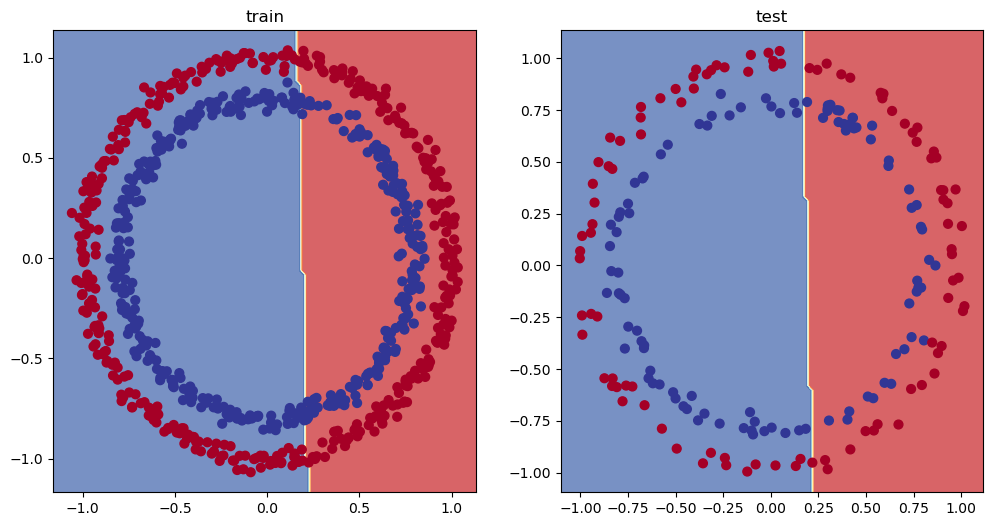

In [21]:
from helper_function import plot_predictions, plot_decision_boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('train')
plot_decision_boundary(model,xtrain,ytrain)

plt.subplot(1,2,2)
plt.title('test')
plot_decision_boundary(model,xtest,ytest)

## 3. Improving the model


parameters and hypermeter tuning
- add more layers
- add more hidden layers
- add more training epochs
- changing the activation function
- change the learing rate
- changing the loss functions 


In [22]:
class CircleModelv2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2,out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        return self.layer3(self.layer2(self.layer1(x)))
    
    
model2 = CircleModelv2().to(device)
model2

CircleModelv2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [24]:
list(model2.parameters())

[Parameter containing:
 tensor([[ 0.5732,  0.2658],
         [ 0.3473,  0.4129],
         [-0.2427,  0.3203],
         [-0.1861, -0.6634],
         [ 0.4029, -0.3410],
         [-0.5538, -0.3917],
         [-0.3924,  0.3217],
         [-0.0536, -0.0032],
         [ 0.3283,  0.4023],
         [ 0.7063,  0.3252]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.5792, -0.3057,  0.5813, -0.4352, -0.0955, -0.2481,  0.0798,  0.6015,
         -0.0222, -0.1490], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.1759, -0.1956, -0.0616, -0.2576,  0.1768,  0.0500,  0.2135, -0.0781,
          -0.1493,  0.2564],
         [ 0.1426,  0.1960,  0.2014,  0.0502,  0.1037,  0.1943, -0.2644,  0.0751,
           0.2020,  0.2305],
         [ 0.1167,  0.2710,  0.1163, -0.2769, -0.1829,  0.1548, -0.1138,  0.0063,
           0.0040,  0.1661],
         [-0.2067, -0.2405,  0.0847,  0.2148, -0.1207, -0.0510,  0.1846,  0.2452,
           0.2533, -0.1331],
         [ 

In [25]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model2.parameters(),lr=0.1)

In [30]:
epochs = 1000

xtrain,ytrain,xtest,ytest = xtrain.to(device), ytrain.to(device),xtest.to(device),ytest.to(device)

for epoch in range(epochs):
    model2.train()
    
    y_logits = model2(xtrain).squeeze()
    ypred=torch.round(torch.sigmoid(y_logits))
    
    train_loss = loss_fn(y_logits,ytrain)
    acc = accuracy_fn(y_true=ytrain,y_pred=ypred)
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    model2.eval()
    with torch.inference_mode():
        test_logits = model2(xtest).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,ytest)
        test_acc = accuracy_fn(y_true=ytest,y_pred=test_pred)
        
    if epoch % 100 == 0:
        print(f'epoch: {epoch} | loss: {train_loss} | accuracy :{acc}  | testloss: {test_loss} | test acc: {test_acc}')

epoch: 0 | loss: 0.6944678425788879 | accuracy :52.25  | testloss: 0.774517834186554 | test acc: 50.0
epoch: 100 | loss: 0.6929801106452942 | accuracy :51.24999999999999  | testloss: 0.6946929693222046 | test acc: 45.5
epoch: 200 | loss: 0.6929798722267151 | accuracy :51.0  | testloss: 0.6946794986724854 | test acc: 46.0
epoch: 300 | loss: 0.6929798722267151 | accuracy :51.0  | testloss: 0.6946795582771301 | test acc: 46.0
epoch: 400 | loss: 0.6929798722267151 | accuracy :51.0  | testloss: 0.6946795582771301 | test acc: 46.0
epoch: 500 | loss: 0.6929798722267151 | accuracy :51.0  | testloss: 0.6946795582771301 | test acc: 46.0
epoch: 600 | loss: 0.6929798722267151 | accuracy :51.0  | testloss: 0.6946795582771301 | test acc: 46.0
epoch: 700 | loss: 0.6929798722267151 | accuracy :51.0  | testloss: 0.6946795582771301 | test acc: 46.0
epoch: 800 | loss: 0.6929798722267151 | accuracy :51.0  | testloss: 0.6946795582771301 | test acc: 46.0
epoch: 900 | loss: 0.6929798722267151 | accuracy :51.

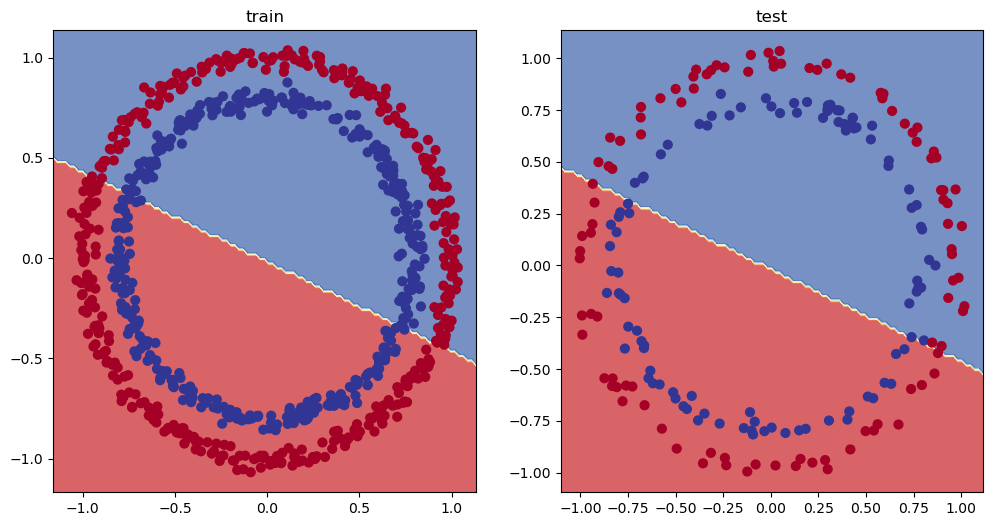

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model2, xtrain, ytrain)

plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model2, xtest, ytest)

In [39]:
class CircleModelv3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2,out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self,x:torch.Tensor)->torch.Tensor:
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
    
    
model3 = CircleModelv3().to(device)
model3

CircleModelv3(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [43]:
optimizer = torch.optim.Adam(model3.parameters(), lr=0.1)
epochs = 1000

epoch_val = []
train_loss_val = []
test_loss_val = []
train_acc_val = []
test_acc_val = []

for epoch in range(epochs):
    model3.train()
    train_logits = model3(xtrain).squeeze()
    train_pred = torch.round(torch.sigmoid(train_logits))
    
    train_loss = loss_fn(train_logits,ytrain)
    train_accuracy = accuracy_fn(ytrain,train_pred)
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()
    
    
    model3.eval()
    with torch.inference_mode():
        test_logits = model3(xtest).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
    test_loss = loss_fn(test_logits, ytest)
    test_accuracy = accuracy_fn(ytest,test_pred)
    
    
    if epoch % 30 == 0:
        print(f'Epoch: {epoch} | Train Loss: {train_loss} | Train accuracy: {train_accuracy} | Test Loss: {test_loss} | Test Accuracy: {test_accuracy}')
        
        epoch_val.append(epoch)
        train_acc_val.append(train_accuracy)
        train_loss_val.append(train_loss)
        
        test_acc_val.append(test_accuracy)
        test_loss_val.append(test_loss)

Epoch: 0 | Train Loss: 0.6945512890815735 | Train accuracy: 50.0 | Test Loss: 0.6993682980537415 | Test Accuracy: 50.0
Epoch: 30 | Train Loss: 0.27745169401168823 | Train accuracy: 94.25 | Test Loss: 0.28090617060661316 | Test Accuracy: 93.5
Epoch: 60 | Train Loss: 0.02202613838016987 | Train accuracy: 100.0 | Test Loss: 0.048408228904008865 | Test Accuracy: 98.0
Epoch: 90 | Train Loss: 0.007248014211654663 | Train accuracy: 100.0 | Test Loss: 0.0229598730802536 | Test Accuracy: 99.5
Epoch: 120 | Train Loss: 0.004662367515265942 | Train accuracy: 100.0 | Test Loss: 0.01936059072613716 | Test Accuracy: 99.5
Epoch: 150 | Train Loss: 0.0033767842687666416 | Train accuracy: 100.0 | Test Loss: 0.017083559185266495 | Test Accuracy: 99.5
Epoch: 180 | Train Loss: 0.002578049898147583 | Train accuracy: 100.0 | Test Loss: 0.013764416798949242 | Test Accuracy: 99.5
Epoch: 210 | Train Loss: 0.0020781927742064 | Train accuracy: 100.0 | Test Loss: 0.011615464463829994 | Test Accuracy: 100.0
Epoch: 2

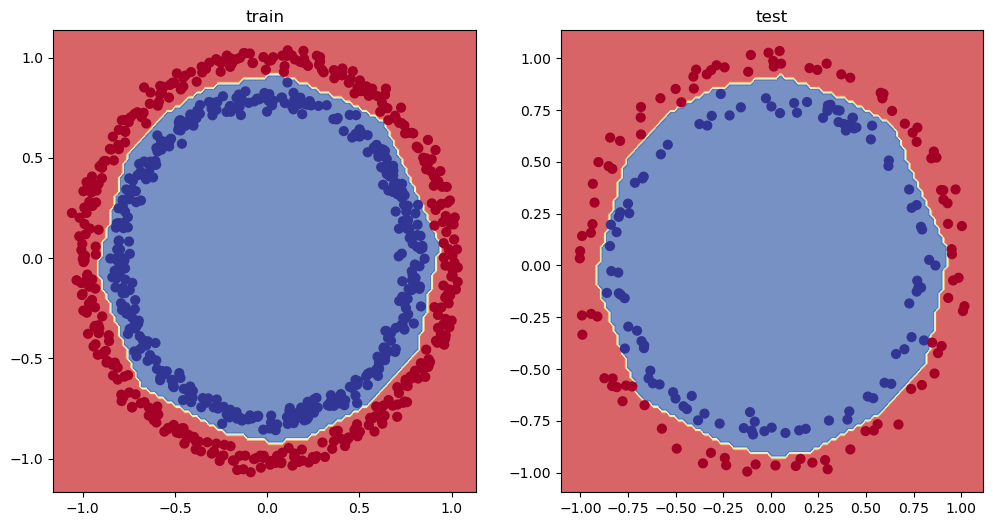

In [44]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model3, xtrain, ytrain)

plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model3, xtest, ytest)